In [159]:
from rosbags.rosbag2 import Reader
from rclpy.serialization import deserialize_message
from beep_interfaces.msg import MotorData, TuningValues, Setpoints
from std_msgs.msg import Float32

from pathlib import Path
from glob import glob
from pid_controller import INITIAL_ANGLE

import numpy as np
import matplotlib.pyplot as plt

In [160]:

class TopicMeta:
    def __init__ (self, name, type):
        self.name = name
        self.type = type

topic_metas = {
    "/dev0/motor_data": TopicMeta("motor0", MotorData),
    "/dev1/motor_data": TopicMeta("motor1", MotorData),
    "/output/tuning_values": TopicMeta("tuning", TuningValues),
    "/output/lean_angle": TopicMeta("lean_angle", Float32),
    "/setpoints": TopicMeta("setpoints", Setpoints),
    "/dev0/duty": TopicMeta("duty", Float32)
}

def get_all_data(path):
    data = {}
    timestamps = {}
    
    #read from rosbags
    with Reader(path) as reader:
        for connection in reader.connections:
            print(connection.topic, connection.msgtype)
            name = topic_metas[connection.topic].name
            data[name] = []
            timestamps[name] = []

        for connection, timestamp, rawdata in reader.messages():
            if connection.topic in topic_metas:
                meta = topic_metas[connection.topic]
                msg = deserialize_message(rawdata, meta.type)
                data[meta.name].append(msg)
                timestamps[meta.name].append(timestamp)

    #turn timestamps to time
    time = timestamps
    for key, val in timestamps.items():
        time[key] = (np.array(val) - val[0]) / 1e9
        
    return data, time

def get_graphable_data(data, time, source, attribute="data"):
    return np.array(list(map(lambda x: getattr(x, attribute), data[source]))), time[source]


In [162]:
bags = glob("../bags/*")
bags.sort()
path = Path(bags[-1])
data, time = get_all_data(path)

/dev0/duty std_msgs/msg/Float32
/output/lean_angle std_msgs/msg/Float32
/setpoints beep_interfaces/msg/Setpoints
/output/tuning_values beep_interfaces/msg/TuningValues
/dev1/motor_data beep_interfaces/msg/MotorData
/dev0/motor_data beep_interfaces/msg/MotorData


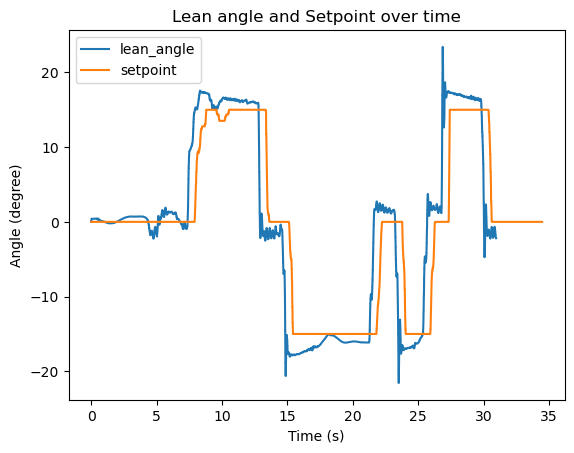

In [167]:
lean_angle, lean_angle_t = get_graphable_data(data, time, "lean_angle", "data")
setpoint, setpoint_t = get_graphable_data(data, time, "setpoints", "lean_angle")

#graph 1
plt.figure()
plt.plot(lean_angle_t, lean_angle)
plt.plot(lean_angle_t, setpoint)

plt.title("Lean angle and Setpoint over time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degree)")
plt.legend(["lean_angle", "setpoint"])

# plt.xlim([21, 23])


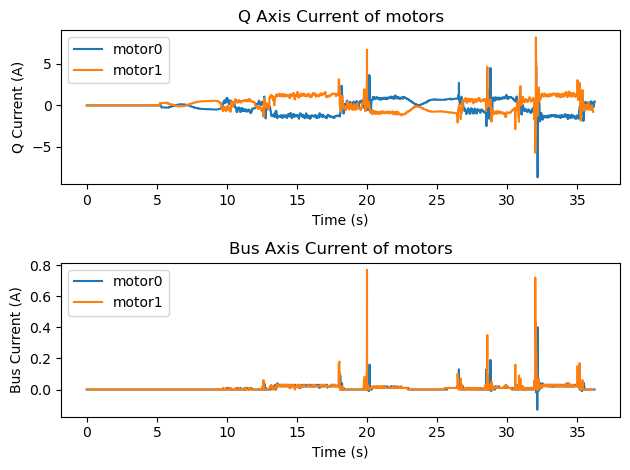

In [164]:
q_current0, q_current0_t = get_graphable_data(data, time, "motor0", "q_current")
q_current1, q_current1_t = get_graphable_data(data, time, "motor1", "q_current")

bus_current0, bus_current0_t = get_graphable_data(data, time, "motor0", "bus_current")
bus_current1, bus_current1_t = get_graphable_data(data, time, "motor1", "bus_current")


fig1, (q_current_ax, bus_current_ax) = plt.subplots(2,1)

q_current_ax.plot(q_current0_t, q_current0)
q_current_ax.plot(q_current1_t, q_current1)
q_current_ax.set_xlabel("Time (s)")
q_current_ax.set_ylabel("Q Current (A)")
q_current_ax.set_title("Q Axis Current of motors")
q_current_ax.legend(["motor0", "motor1"])

bus_current_ax.plot(bus_current0_t, bus_current0)
bus_current_ax.plot(bus_current1_t, bus_current1)
bus_current_ax.set_xlabel("Time (s)")
bus_current_ax.set_ylabel("Bus Current (A)")
bus_current_ax.set_title("Bus Axis Current of motors")
bus_current_ax.legend(["motor0", "motor1"])

fig1.tight_layout()


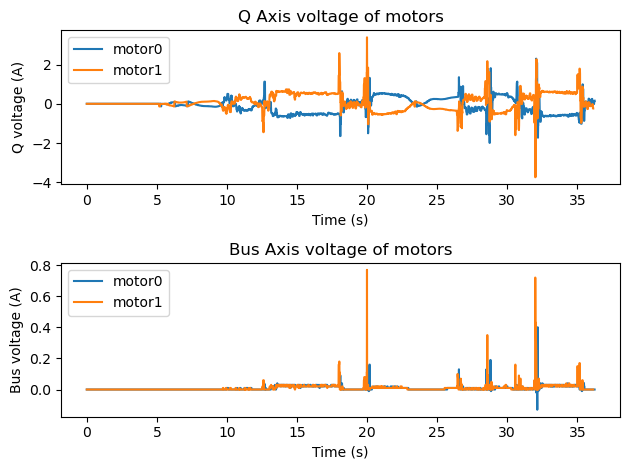

In [165]:
q_voltage0, q_voltage0_t = get_graphable_data(data, time, "motor0", "q_voltage")
q_voltage1, q_voltage1_t = get_graphable_data(data, time, "motor1", "q_voltage")

bus_voltage0, bus_voltage0_t = get_graphable_data(data, time, "motor0", "bus_voltage")
bus_voltage1, bus_voltage1_t = get_graphable_data(data, time, "motor1", "bus_voltage")


fig2, (q_voltage_ax, bus_voltage_ax) = plt.subplots(2,1)

q_voltage_ax.plot(q_voltage0_t, q_voltage0)
q_voltage_ax.plot(q_voltage1_t, q_voltage1)
q_voltage_ax.set_xlabel("Time (s)")
q_voltage_ax.set_ylabel("Q voltage (A)")
q_voltage_ax.set_title("Q Axis voltage of motors")
q_voltage_ax.legend(["motor0", "motor1"])

bus_voltage_ax.plot(bus_voltage0_t, bus_voltage0)
bus_voltage_ax.plot(bus_voltage1_t, bus_voltage1)
bus_voltage_ax.set_xlabel("Time (s)")
bus_voltage_ax.set_ylabel("Bus voltage (A)")
bus_voltage_ax.set_title("Bus Axis voltage of motors")
bus_voltage_ax.legend(["motor0", "motor1"])

fig2.tight_layout()


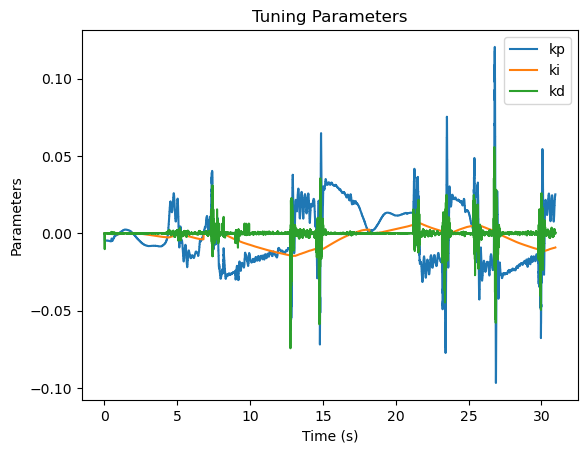

In [163]:
kp, tune_t = get_graphable_data(data, time, "tuning", "kp")
ki, tune_t= get_graphable_data(data, time, "tuning", "ki")
kd, tune_t = get_graphable_data(data, time, "tuning", "kd")



fig2, ax2 = plt.subplots()
ax2.plot(tune_t, kp)
ax2.plot(tune_t, ki)
ax2.plot(tune_t, kd)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Parameters")
ax2.set_title("Tuning Parameters")
ax2.legend(["kp", "ki", "kd"])

# ax2.set_xlim([19,25])

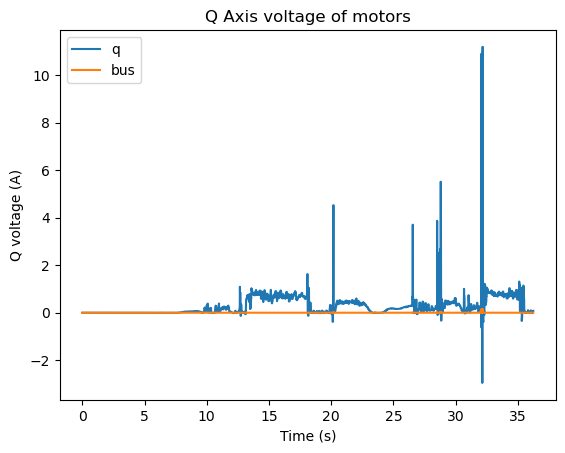

In [166]:
q_current0, q_current0_t = get_graphable_data(data, time, "motor0", "q_current")
bus_current0, bus_current0_t = get_graphable_data(data, time, "motor0", "bus_current")

q_voltage0, q_voltage0_t = get_graphable_data(data, time, "motor0", "q_voltage")
bus_voltage0, bus_voltage0_t = get_graphable_data(data, time, "motor0", "bus_voltage")

motor0_q = q_current0 * q_voltage0
motor0_bus = bus_current0 * bus_voltage0

fig3, motor0_ax = plt.subplots()

motor0_ax.plot(q_current0_t, motor0_q)
motor0_ax.plot(q_current0_t, motor0_bus)
motor0_ax.set_xlabel("Time (s)")
motor0_ax.set_ylabel("Q voltage (A)")
motor0_ax.set_title("Q Axis voltage of motors")
motor0_ax.legend(["q", "bus"])


fig2.tight_layout()
